In [22]:
import pandas as pd
from example.nuscenes.av_discretizer  import AVDiscretizer
from example.nuscenes.transition import TransitionRecorded
from nuscenes import NuScenes
import matplotlib.pyplot as plt
from pathlib import Path
import pgeon.policy_graph as PG
from example.nuscenes.environment import SelfDrivingEnvironment


In [23]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes')

#MINI
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)


#FULL
#DATAROOT = Path('/media/saramontese/Riccardo 500GB/NuScenesDataset/data/sets/nuscenes')
#nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

AssertionError: Database version not found: /home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes/v1.0-trainval

The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in

Load the CSV data into a DataFrame


In [ ]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'
}
df = pd.read_csv(DATAROOT / 'dataset_from_ego.csv', dtype=dtype_dict, parse_dates=['timestamp'])

df.head()

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
0,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.301132,"[-0.1557237496690409, 0.011222825001502285, 0....",329.647494,660.196689,0.0,2.828707,5.108550,-0.034804,-0.045330,0.000000,0.000000
1,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.801064,"[-0.16117694469754024, 0.009157178788916257, 0...",327.233834,661.025514,0.0,2.817706,5.104695,-0.007711,-0.022006,0.045648,2.551592
2,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.200261,"[-0.16222999791894513, 0.010261981974878865, -...",325.362312,661.686833,0.0,2.815673,4.972301,-0.331650,-0.005091,0.031316,1.984681
3,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.651414,"[-0.16605361559690043, 0.007585584174464603, -...",323.362925,662.405363,0.0,2.807968,4.709219,-0.583132,-0.017080,0.040541,2.124192
4,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:11.149672,"[-0.1790782272855317, 0.009448521999393368, -0...",321.358449,663.164911,0.0,2.781689,4.302103,-0.817080,-0.052741,0.061262,2.142681


## Trajectory of AV in a Scene

Let's do an example of computing trajectory of a vehicle in a scene. We then check if the rendering of the scene match the computed trajectory.

In [ ]:
# initialize discretizer
av_discretizer = AVDiscretizer()


List of scenes

In [ ]:
df['scene_token'].unique()

array(['2fc3753772e241f2ab2cd16a784cc680',
       '325cef682f064c55a255f2625c533b75',
       '6f83169d067343658251f72e1dd17dbc',
       'bebf5f5b2a674631ab5c88fd1aa9e87a',
       'c5224b9b454b4ded9b5d2d2634bbda8a',
       'cc8c0bf57f984915a77078b10eb33198',
       'd25718445d89453381c659b9c8734939',
       'de7d80a1f5fb4c3e82ce8a4f213b450a',
       'e233467e827140efa4b42d2b4c435855',
       'fcbccedd61424f1b85dcbf8f897f9754'], dtype=object)

Select a scene and test the  algorithm


In [ ]:
scene_test = df['scene_token'].unique()[6]
example_scene_df = df[df['scene_token']==scene_test]
example_scene_df

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
231,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:28.948430,"[0.8528977604944997, 0.0005375172497731908, 0....",610.384463,2004.811594,0.0,-1.098554,6.690875,0.910698,0.442861,0.000000,0.000000
232,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:29.448339,"[0.8965811993783813, 0.0016462198909647716, 0....",612.235641,2001.769059,0.0,-0.917523,7.124184,0.866776,0.362127,-0.264566,3.551603
233,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:29.949334,"[0.9223652655739288, -0.0036955010565602737, 0...",614.784636,1998.776777,0.0,-0.793150,7.845971,1.440708,0.248252,-0.205478,3.925418
234,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:30.450291,"[0.9293486187439918, -0.003444821268387805, 0....",617.830057,1995.731590,0.0,-0.756233,8.596965,1.499119,0.073694,-0.033552,4.306579
235,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:30.949037,"[0.9311700712966873, -0.005286952440806329, 0....",621.237699,1992.493032,0.0,-0.746249,9.425828,1.661893,0.020018,0.017536,4.701061
236,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:31.448359,"[0.9322349071936953, -0.008188971784560756, 0....",624.940162,1989.017849,0.0,-0.740234,10.169601,1.489566,0.012047,0.038057,5.077763
237,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:31.948272,"[0.9326011121492934, -0.00800130488593488, 0.0...",628.804714,1985.446999,0.0,-0.738260,10.525279,0.711481,0.003948,0.029911,5.261639
238,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:32.397808,"[0.9328338676688567, -0.005470017747022805, 0....",632.467505,1982.078368,0.0,-0.737017,11.069891,1.211496,0.002766,0.026511,4.976244
239,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:32.948008,"[0.9324113142508007, -0.005880890523709449, 0....",637.069856,1977.823420,0.0,-0.739379,11.391989,0.585420,-0.004293,0.057535,6.267608
240,lidar,d25718445d89453381c659b9c8734939,2018-11-21 11:39:33.447883,"[0.9321244841259677, -0.013557117585724438, 0....",641.349321,1973.876850,0.0,-0.740492,11.645804,0.507756,-0.002228,0.032444,5.821356


Compute the trajectoy of the scene

In [ ]:
recorder = TransitionRecorded()
trajectory = av_discretizer.compute_trajectory(example_scene_df)
recorder.process_and_save_transitions(trajectory, av_discretizer.unique_states)

State 0: [0.0, 0.0, 6.690875059141553, 0.4428611706958376, 0.9106983699768684]
Discretized state: 0 [152, 501]&[<Velocity.MEDIUM: 3>]&[<Rotation.SLIGHT_LEFT: 2>]
Action: Action.GAS_TURN_LEFT id: 9

State 1: [-0.2645655833291627, 3.551603317020338, 7.124183956858491, 0.3621269887743466, 0.8667755485837172]
Discretized state: 1 [153, 500]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: Action.GAS_TURN_LEFT id: 9

State 2: [-0.205478131468545, 3.925418116783829, 7.845971256699597, 0.248251649174793, 1.440707591574979]
Discretized state: 2 [153, 499]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: Action.GAS_STRAIGHT id: 10

State 3: [-0.0335521890955035, 4.30657924553862, 8.596965297754897, 0.0736942592726639, 1.4991187687871417]
Discretized state: 3 [154, 498]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: Action.GAS_STRAIGHT id: 10

State 4: [0.0175360909472814, 4.701061265962645, 9.42582792196949, 0.0200178672449955, 1.6618932767673165]
Discretized state: 4 [155, 

Plot trend of state in time for each instance of a scene.

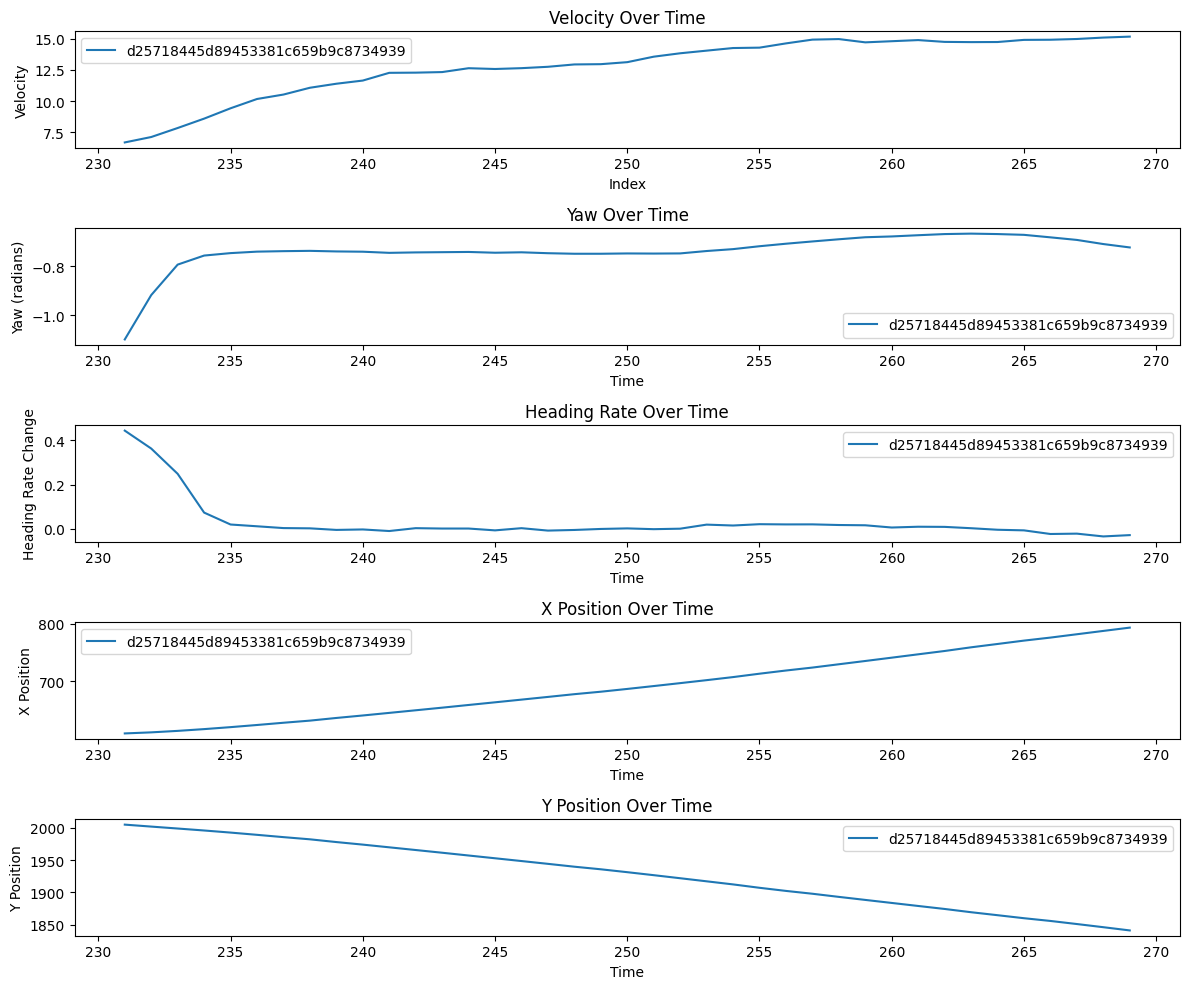

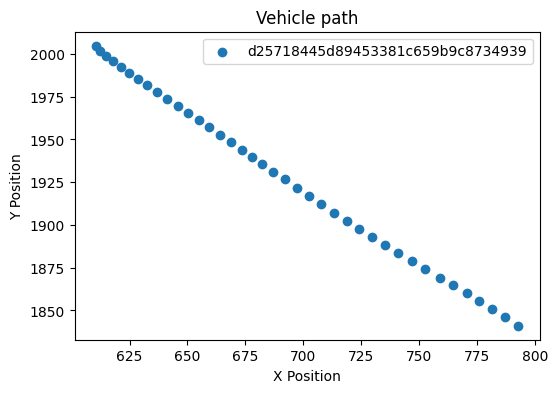

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['velocity'], label=scene_token)
plt.title('Velocity Over Time')
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(5, 1, 2)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['yaw'], label=scene_token)
plt.title('Yaw Over Time')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()

plt.subplot(5, 1, 3)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['heading_change_rate'], label=scene_token)
plt.title('Heading Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heading Rate Change')
plt.legend()

plt.subplot(5, 1, 4)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['x'], label=scene_token)
plt.title('X Position Over Time')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.legend()

plt.subplot(5, 1, 5)  # Moved inside the same plt.figure block
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['y'], label=scene_token)
plt.title('Y Position Over Time')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()

plt.tight_layout()
plt.show()


# Plot x vs y positions for each instance
plt.figure(figsize=(6, 4))
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.scatter(group['x'], group['y'], label=scene_token)
plt.title('Vehicle path')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

To render the scene (video):

In [ ]:
#nuscenes.render_scene(scene_test)



## All scenes trajectory information


Now, apply the above to all scenes in the dataset.

In [ ]:
av_discretizer = AVDiscretizer()

trajectory = av_discretizer.compute_trajectory(df)

State 0: [0.0, 0.0, 5.108549775006556, -0.0453298240761698, -0.0348037318593867]
Discretized state: 0 [82, 165]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: Action.STRAIGHT id: 7

State 1: [0.0456478454936385, 2.5515920468546924, 5.10469490440442, -0.0220058832146411, -0.007710789871694]
Discretized state: 1 [81, 165]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: Action.BRAKE_STRAIGHT id: 13

State 2: [0.0313156638906143, 1.9846806565211763, 4.972301147669266, -0.0050912652853189, -0.3316501795733787]
Discretized state: 2 [81, 165]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: Action.BRAKE_STRAIGHT id: 13

State 3: [0.0405408994690575, 2.1241916563087795, 4.709219465049271, -0.0170801794347065, -0.5831318479983395]
Discretized state: 3 [80, 165]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: Action.BRAKE_STRAIGHT id: 13

State 4: [0.0612618323316302, 2.142681440792965, 4.302102598495416, -0.0527406448615074, -0.8170804413654266]
Discretized state: 4 [80, 165]&[<Velocity

In [ ]:
transition = TransitionRecorded()

path_pg_data = Path('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes')
transition.process_and_save_transitions(trajectory, av_discretizer.unique_states, path=str(path_pg_data))

# Policy Graph Generation

In [ ]:
env = SelfDrivingEnvironment()
av_discretizer = AVDiscretizer()
pg = PG.PolicyGraph.from_nodes_and_edges(str(path_pg_data / 'nuscenes_nodes.csv'), str(path_pg_data / 'nuscenes_edges.csv'), env, av_discretizer  )

In [ ]:
print(f'Number of nodes: {len(pg.nodes)}')
print(f'Number of edges: {len(pg.edges)}')

Number of nodes: 229
Number of edges: 283


In [ ]:
arbitrary_state = list(pg.nodes)[10]

print(arbitrary_state)
print(f'  Times visited: {pg.nodes[arbitrary_state]["frequency"]}')
print(f'  p(s):          {pg.nodes[arbitrary_state]["probability"]:.3f}')

((178, 451), <Velocity.LOW: 2>, <Rotation.SLIGHT_LEFT: 2>)
  Times visited: 1
  p(s):          0.003


In [ ]:
arbitrary_edge = list(pg.edges)[10]

print(f'From:    {arbitrary_edge[0]}')
print(f'Action:  {arbitrary_edge[2]}')
print(f'To:      {arbitrary_edge[1]}')
print(f'  Times visited:      {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["frequency"]}')
print(f'  p(s_to,a | s_from): {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["probability"]:.3f}')

From:    ((77, 166), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>)
Action:  13
To:      ((77, 166), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>)
  Times visited:      1
  p(s_to,a | s_from): 0.500


### Using PG-based policies

In [ ]:
from pgeon import PGBasedPolicy, PGBasedPolicyMode, PGBasedPolicyNodeNotFoundMode

In [ ]:
policy = PGBasedPolicy(pg, mode=PGBasedPolicyMode.GREEDY,
                       node_not_found_mode=PGBasedPolicyNodeNotFoundMode.RANDOM_UNIFORM)

In [ ]:
print(f'Number of nodes: {len(policy.pg.nodes)}')
print(f'Number of edges: {len(policy.pg.edges)}')

Number of nodes: 229
Number of edges: 283


In [ ]:
arbitrary_state = list(policy.pg.nodes)[10]

print(arbitrary_state)
print(f'  Times visited: {policy.pg.nodes[arbitrary_state]["frequency"]}')
print(f'  p(s):          {policy.pg.nodes[arbitrary_state]["probability"]:.3f}')

((178, 451), <Velocity.LOW: 2>, <Rotation.SLIGHT_LEFT: 2>)
  Times visited: 1
  p(s):          0.003


In [ ]:
obs = [0, 12, 100, 20]
discretized_obs = policy.pg.discretizer.discretize(obs)
str_obs = av_discretizer.state_to_str(discretized_obs)
str_to_state = av_discretizer.str_to_state(str_obs)
action = policy.act(obs)

print(f'Observed state:  {obs}')
print(f'Discretization:  {discretized_obs}')
print(f'State to str:    {str_obs}')
print(f'Str to state:    {str_to_state}')
print(f'Selected action: {action}')

Observed state:  [0, 12, 100, 20]
Discretization:  (Position(0;3), Velocity(VERY_HIGH), Rotation(RIGHT))
State to str:    [0, 3]&[<Velocity.VERY_HIGH: 5>]&[<Rotation.RIGHT: 5>]
Str to state:    ((0, 3), <Velocity.VERY_HIGH: 5>, <Rotation.RIGHT: 5>)
Selected action: 1


In [ ]:
possible_actions = pg.question1(discretized_obs)

print(f'From {discretized_obs}, I will take one of these actions:')
for action, prob in possible_actions:
    print('\t->', action.name, '\tProb:', round(prob * 100, 2), '%')

From (Position(0;3), Velocity(VERY_HIGH), Rotation(RIGHT)), I will take one of these actions:
	-> IDLE 	Prob: 7.69 %
	-> TURN_LEFT 	Prob: 7.69 %
	-> TURN_RIGHT 	Prob: 7.69 %
	-> GAS 	Prob: 7.69 %
	-> BRAKE 	Prob: 7.69 %
	-> REVERSE 	Prob: 7.69 %
	-> STRAIGHT 	Prob: 7.69 %
	-> GAS_TURN_RIGHT 	Prob: 7.69 %
	-> GAS_TURN_LEFT 	Prob: 7.69 %
	-> GAS_STRAIGHT 	Prob: 7.69 %
	-> BRAKE_TURN_RIGHT 	Prob: 7.69 %
	-> BRAKE_TURN_LEFT 	Prob: 7.69 %
	-> BRAKE_STRAIGHT 	Prob: 7.69 %
